# Лабораторная работа 3. Статистические гипотезы.

## Reading data and creating table of interval variational series (аналогично первой лабораторной работе)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_to_data = "data.xlsx"
df = pd.read_excel(path_to_data)
df.head()
writing_score = df['writing score'].copy()
reading_score = df['reading score'].copy()

writing_score.sort_values(inplace=True)
writing_score.reset_index(inplace=True, drop=True)
reading_score.sort_values(inplace=True)
reading_score.reset_index(inplace=True, drop=True)

writing_min = min(writing_score.min(), reading_score.min())
writing_max = max(writing_score.max(), reading_score.max())
writing_elements_count = writing_score.count()
writing_range = writing_max - writing_min 
writing_intervals_count = 15
writing_len_interval = writing_range / writing_intervals_count
writing_a = [writing_min + i*writing_len_interval for i in range(writing_intervals_count + 1)]
writing_points = [(writing_a[i] + writing_a[i + 1]) / 2 for i in range(writing_intervals_count)]
writing_indicates = writing_score.groupby(pd.cut(writing_score, writing_a, include_lowest=True)).count()
writing_indicates = pd.Series(index=writing_points, data=writing_indicates)
writing_indicates.name = 'indicates'
writing_frequency = writing_indicates / writing_elements_count
writing_frequency.name = 'frequency'
writing_hist = writing_frequency / writing_len_interval
writing_hist.name = "hist"
writing_F = writing_frequency.cumsum()
writing_F.name = 'F'
expect_writing_score = writing_points * writing_frequency
expect_writing_score.name = "expect"
expect_square_writing_score = (writing_points * writing_frequency) * writing_points
expect_square_writing_score.name = 'expect_square'

reading_min = min(writing_score.min(), reading_score.min())
reading_max = max(writing_score.max(), reading_score.max())
reading_elements_count = reading_score.count()
reading_range = reading_max - reading_min 
reading_intervals_count = 15
reading_len_interval = reading_range / reading_intervals_count
reading_a = [reading_min + i*reading_len_interval for i in range(reading_intervals_count + 1)]
reading_points = [(reading_a[i] + reading_a[i + 1]) / 2 for i in range(reading_intervals_count)]
reading_indicates = reading_score.groupby(pd.cut(reading_score, reading_a, include_lowest=True)).count()
reading_indicates = pd.Series(index=reading_points, data=reading_indicates)
reading_indicates.name = 'indicates'
reading_frequency = reading_indicates / reading_elements_count
reading_frequency.name = 'frequency'
reading_hist = reading_frequency / reading_len_interval
reading_hist.name = "hist"
reading_F = reading_frequency.cumsum()
reading_F.name = 'F'
expect_reading_score = reading_points * reading_frequency
expect_reading_score.name = "expect"
expect_square_reading_score = (reading_points * reading_frequency) * reading_points
expect_square_reading_score.name = 'expect_square'

from math import sqrt
writing_sample_expect = sum(expect_writing_score)
writing_sample_var = sum(expect_square_writing_score) - (sum(expect_writing_score)) ** 2
writing_sample_var_unb = writing_elements_count/(writing_elements_count-1)*writing_sample_var
reading_sample_expect = sum(expect_reading_score)
reading_sample_var = sum(expect_square_reading_score) - (sum(expect_reading_score)) ** 2
reading_sample_var_unb = reading_elements_count/(reading_elements_count-1)*reading_sample_var
reading_std = sqrt(reading_sample_var_unb)

## Проверка на однородность reading_score and writing_score с помощью критерия Колмогорова Смирнова

$$ D_{n,m}= \sup_{-\infty<x<\infty} |\hat{F}_{1n}(x) - \hat{F}_{2m}(x)| \text{ - статистика Колмогорова}$$
$$ 1 - K(\lambda_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow  D_{n,m} > \lambda_{\alpha}\sqrt{\frac{1}{n}+\frac{1}{m}} \text {  - Критерий однородности Смирнова-Колмогорова}$$

In [3]:
from scipy.stats import kstwobign
from math import sqrt
def statitic_k(F_X, F_Y):
    D = abs(F_X - F_Y)
    return max(D), D.idxmax()

def ks_2test(F_X, F_Y, n, m, alpha=0.05):
    D, x = statitic_k(F_X, F_Y)
    t = kstwobign.ppf(1 - alpha)
    return {'H0': not sqrt((n*m)/(n+m))*D >= t, 'statitic': D, 'x': x}

result = ks_2test(writing_F, reading_F, len(reading_score), len(writing_score))

[]

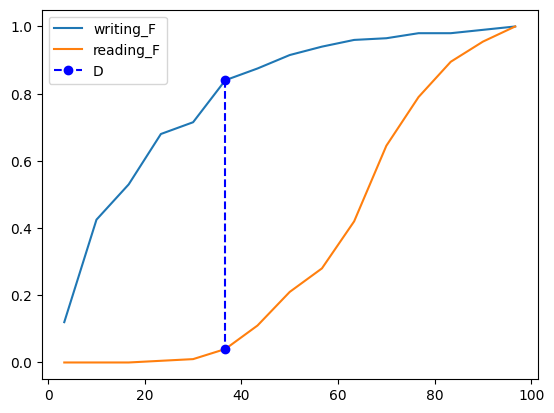

In [4]:
fig, ax = plt.subplots()
ax.plot(writing_F)[0].set_label('writing_F')
ax.plot(reading_F)[0].set_label('reading_F')
x_values = [result['x'], result['x']]
y_values = [writing_F[result['x']], reading_F[result['x']]]
ax.plot(x_values, y_values, 'bo', linestyle="--")[0].set_label('D')
ax.legend()
ax.plot()

Из теста Колмогорова-Смирнова следует, что выборки из разных распредлений

## Проверка на принадлежность reading score к классу равномерных распредлений с помощью критерия Колмогорова

$$ D_{n}= \sup_{-\infty<x<\infty} |F(x) - \hat{F}_{n}(x)| \text{ - статистика Колмогорова}$$
$$ 1 - K(t_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow  \sqrt{n}*D_{n} > t_{\alpha} \text {  - Критерий согласия Колмогорова}$$
$$ \text{ Оценим параметры равномерного распредления по методу максимального правдоподобия}:$$
$$ \; \hat{a} = min(X_1,X_2...X_n), \hat{b} = min(X_1,X_2...X_n)$$
$$ \text {Далее будем проверять reading score на согласаие с } U_{\hat{a},\hat{b}} $$

In [5]:
def ks_test(F_X, F_Y, n, alpha=0.05):
    D, x = statitic_k(F_X, F_Y)
    t = kstwobign.ppf(1 - alpha)
    return {'H0': not sqrt(n)*D >= t, 'statitic': D, 'x': x}

# generate uniform distribution with givan a, b
a = min(reading_points)
b = max(reading_points)
value_F = [(x - a)/(b - a) for x in reading_points]
F = pd.Series(value_F, reading_F.index)

ks_test(F, reading_F, len(reading_F))

{'H0': True, 'statitic': 0.3185714285714285, 'x': 43.333333333333336}

[]

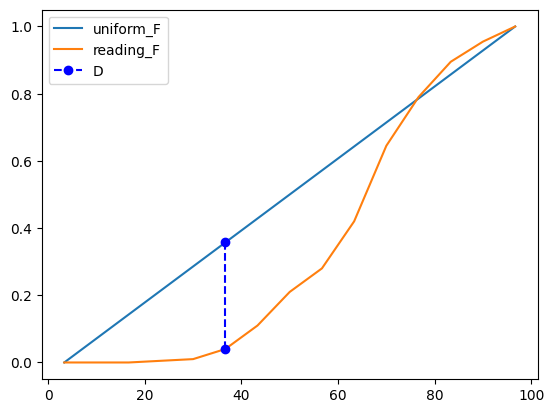

In [6]:
fig, ax = plt.subplots()
ax.plot(F)[0].set_label('uniform_F')
ax.plot(reading_F)[0].set_label('reading_F')
x_values = [result['x'], result['x']]
y_values = [F[result['x']], reading_F[result['x']]]
ax.plot(x_values, y_values, 'bo', linestyle="--")[0].set_label('D')
ax.legend()
ax.plot()

Из теста Колмогорова следует, что reading распределен равномерно.

## Проверка на принадлежность writing score к классу Пуассоновских распредлений с помощью критерия Хи квадрат

$$ \overset{\circ}{\chi}_n=\sum_j^N{\frac{(\nu_i - np^{\circ})^2}{{np^{\circ}}^2}} \text{ - статистика Колмогорова}$$
$$ 1 - \chi^2_{N-1}(t_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow \overset{\circ}{\chi}_n  > t_{\alpha} \text {  - Критерий согласия хи квадрат}$$
$$ \text{ Оценим параметры Пуассоновского распредления по методу максимального правдоподобия}:$$
$$ \hat{\lambda}  = \overline{X}$$
$$ \text {Далее будем проверять writing на согласаие с } Poiss({\hat{\lambda}}) $$

In [40]:
from math import pow,  exp, factorial
from scipy.stats import chi2
def statistic_chi2(freq, p, n):
    chi2_v = 0
    for i in range(len(p)):
        chi2_v += pow(freq[i] - n*p[i], 2)/(n*p[i])
    return chi2_v
def chi2_test(freq, p, n, alpha=0.05):
    t = chi2.ppf(1-alpha, len(freq) - 1)
    statistic = statistic_chi2(freq, p, n)
    return {'H0': not statistic > t, 'statistic': statistic}

In [41]:
# generate poiison distribution with given lam
lam = writing_sample_expect
p = [pow(lam, int(x))/factorial(int(x))*exp(-lam) for x in writing_points]

In [42]:
chi2_test(writing_indicates.values, p, len(writing_score))

{'H0': False, 'statistic': 2.2436831207658754e+26}

Text(0.5, 1.0, 'writing score')

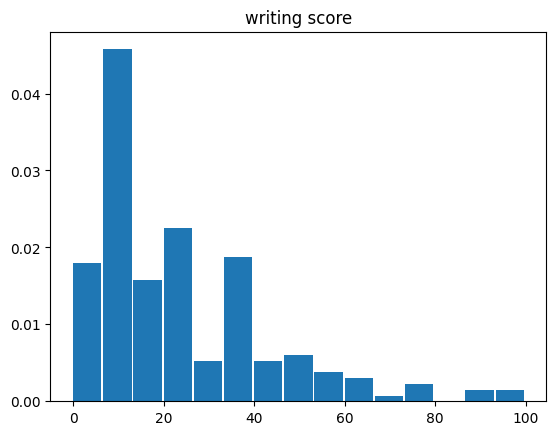

In [43]:
fig, ax = plt.subplots()
ax.bar(writing_a[:writing_intervals_count], writing_hist.values, width=writing_len_interval-0.4, align='edge')
ax.set_title('writing score')

Text(0.5, 1.0, 'poisson ditribution')

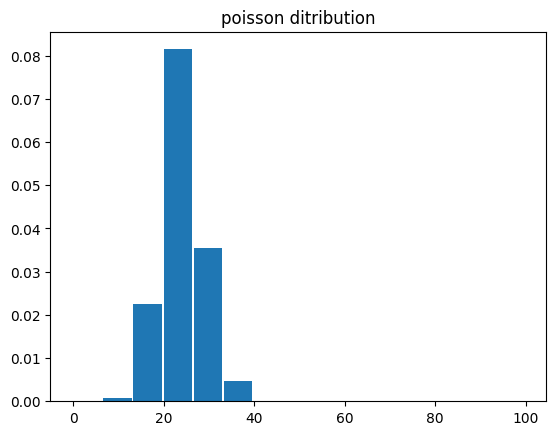

In [44]:
fig, ax = plt.subplots()
ax.bar(writing_a[:writing_intervals_count], p, width=writing_len_interval-0.4, align='edge')
ax.set_title('poisson ditribution')

Из теста хи квадрат следует, что writing score  не согласуется с распределением Пуассона.

## Проверка на принадлежность writing score к классу экспоненциальных распредлений с помощью критерия Хи квадрат

$$ \text{ Оценим параметры экспоненциального распредления по методу максимального правдоподобия}:$$
$$ \hat{\lambda}  = \overline{X}$$
$$ \text {Далее будем проверять writing на согласаие с } Exp({\hat{\lambda}}) $$

In [54]:
# generate poiison distribution with given lam
lam = 1/writing_sample_expect
p = [lam*exp(-lam*x) for x in writing_points]
p, writing_indicates.values, writing_points, lam

([0.03639410482239067,
  0.027535243836975403,
  0.02083276005445894,
  0.015761759512870652,
  0.011925115169192146,
  0.009022366550027163,
  0.006826189685224117,
  0.0051645946061147155,
  0.003907456234807732,
  0.0029563238533496412,
  0.0022367110981382794,
  0.0016922626832193885,
  0.0012803410290227117,
  0.000968687170646792,
  0.0007328944502324784],
 array([24, 61, 21, 30,  7, 25,  7,  8,  5,  4,  1,  3,  0,  2,  2],
       dtype=int64),
 [3.3333333333333335,
  10.0,
  16.666666666666668,
  23.333333333333336,
  30.0,
  36.66666666666667,
  43.333333333333336,
  50.0,
  56.66666666666667,
  63.333333333333336,
  70.0,
  76.66666666666667,
  83.33333333333334,
  90.0,
  96.66666666666667],
 0.041841004184100423)

In [55]:
chi2_test(writing_indicates.values, p, len(writing_score))

{'H0': False, 'statistic': 1376.175796782365}

Text(0.5, 1.0, 'exponential distribution')

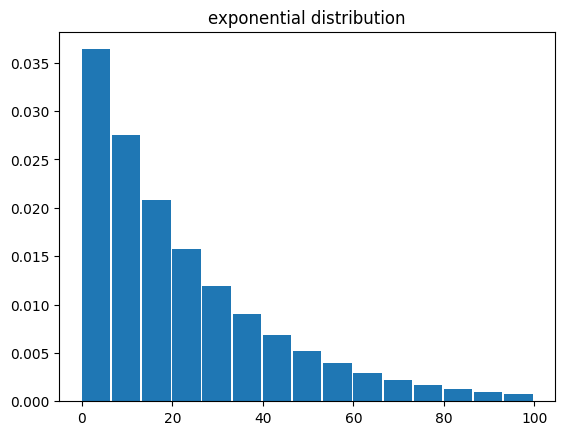

In [56]:
fig, ax = plt.subplots()
ax.bar(writing_a[:writing_intervals_count], p, width=writing_len_interval-0.4, align='edge')
ax.set_title('exponential distribution')

Из теста хи квадрат следует, что writing score  не согласуется с экспоненциальным распределением.

## Проверка на принадлежность reading score к классу нормальных распредлений с помощью критерия Колмогорова

In [58]:
from math import pi, erf
# generate normal distribution with givan mu, sigma
mu = reading_sample_expect
sigma = reading_sample_var
value_F = [p[i]*reading_points[i] for i in range(len(p))]
F = pd.Series(value_F, reading_F.index)
F

3.333333     0.000014
10.000000    0.000230
16.666667    0.001776
23.333333    0.009540
30.000000    0.038979
36.666667    0.125413
43.333333    0.323200
50.000000    0.673619
56.666667    1.142313
63.333333    1.582418
70.000000    1.795710
76.666667    1.672678
83.333333    1.280885
90.000000    0.807305
96.666667    0.419174
dtype: float64

In [61]:
ks_test(reading_F, F, len(reading_score))

{'H0': False, 'statitic': 1.1624176746228887, 'x': 63.333333333333336}

Text(0.5, 1.0, 'writing score')

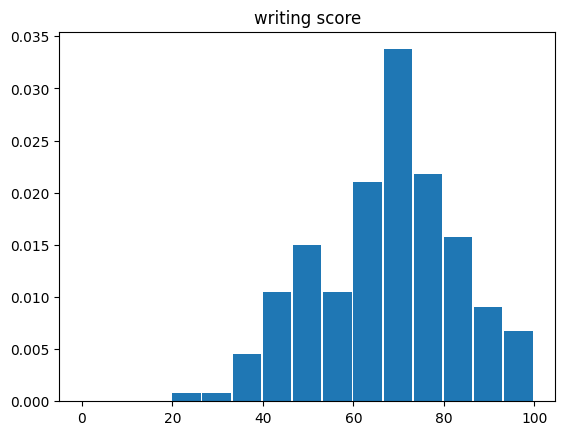

Text(0.5, 1.0, 'normal ditribution')

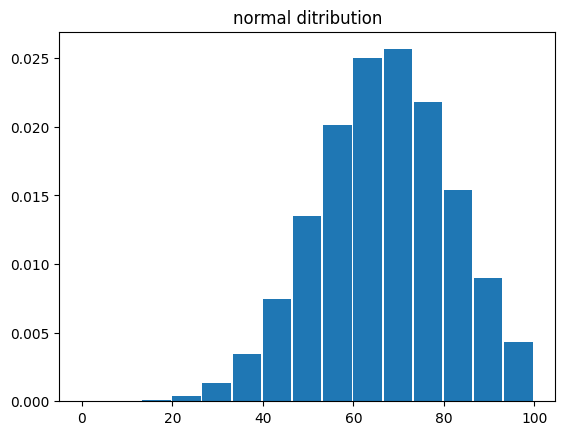

In [63]:
fig, ax = plt.subplots()
ax.bar(reading_a[:writing_intervals_count], p, width=reading_len_interval-0.4, align='edge')
ax.set_title('normal ditribution')